# MobileNetV2 Pretraining on UnityEyes

In [ ]:
!pip uninstall -y tensorflow
!pip install tensorflow==2.18.0
!pip install tensorflowjs

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

random.seed(42028)

In [ ]:
!nvidia-smi

Mon May 26 08:51:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   53C    P8             17W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
print("TF Version:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

TF Version: 2.18.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PROJECT_DIR = "/content/drive/Shareddrives/OmniClick Team"
DATA_ROOT_DIR = os.path.join(PROJECT_DIR, "datasets")
UNITY_DATA_DIR = os.path.join(DATA_ROOT_DIR, 'UnityEyes')
UNITY_SUBSET_DIR = os.path.join(DATA_ROOT_DIR, 'UnityEyesSubset')

BEST_MODEL_PATH = os.path.join(PROJECT_DIR, "notebooks/weights/mobilenetv2_unity_best.keras")
LAST_MODEL_PATH = os.path.join(PROJECT_DIR, "notebooks/weights/mobilenetv2_unity_last.keras")
TFJS_MODEL_DIR = os.path.join(PROJECT_DIR, "notebooks/weights/mobilenetv2_unity_tfjs")
TF_SAVE_MODEL_DIR = os.path.join(PROJECT_DIR, "notebooks/weights/mobilenetv2_unity_tf")

In [ ]:
%ls "$DATA_ROOT_DIR"

columbia_gaze_data_set.zip  OurWebcamDataset/  UnityEyesSubset/  u_train.zip
ColumbiaGazeProcessed/      UnityEyes/         u_test.zip        u_val.zip


In [ ]:
IMG_SIZE = (96, 96)
BATCH_SIZE = 32

unity_train_dir = os.path.join(UNITY_SUBSET_DIR, 'train')
unity_val_dir = os.path.join(UNITY_SUBSET_DIR, 'val')
unity_test_dir = os.path.join(UNITY_SUBSET_DIR, 'test')
unity_class_names = sorted(os.listdir(unity_train_dir))
unity_class_indices = {name: idx for idx, name in enumerate(unity_class_names)}
NUM_CLASSES_UNITY = len(unity_class_names)

# Data Aug for Unity set
unity_train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    brightness_range=[0.7, 1.3],
    zoom_range=0.1,
    horizontal_flip=True
).flow_from_directory(
    unity_train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
unity_val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    unity_val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
unity_test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    unity_test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# LR Scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       # shrink LR by half
    patience=15,       # wait 5 epochs with no improvement
    cooldown=5,
    min_lr=1e-6,
    verbose=1
)

# Checkpoints
callbacks = [
    ModelCheckpoint(
        BEST_MODEL_PATH,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    ModelCheckpoint(
        LAST_MODEL_PATH,
        save_best_only=False,
        save_weights_only=False,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    )
]

Found 6103 images belonging to 8 classes.
Found 7247 images belonging to 8 classes.
Found 11333 images belonging to 8 classes.


In [ ]:
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(NUM_CLASSES_UNITY, activation='softmax')(x)

optimizer = tf.keras.optimizers.AdamW(learning_rate=3e-4, weight_decay=1e-5)
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train
history = model.fit(
    unity_train_gen,
    validation_data=unity_val_gen,
    epochs=100,
    callbacks=callbacks
)
model.export(TF_SAVE_MODEL_DIR)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.3411 - loss: 1.8021
Epoch 1: val_loss improved from inf to 1.49252, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_unity_best.keras

Epoch 1: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_unity_last.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 1462s 7s/step - accuracy: 0.3416 - loss: 1.8005 - val_accuracy: 0.4105 - val_loss: 1.4925
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.5844 - loss: 1.0356
Epoch 2: val_loss improved from 1.49252 to 1.34736, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_unity_best.keras

Epoch 2: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_unity_last.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 57s 301ms/step - accuracy: 0.5847 - loss: 1.0350 - val_accuracy: 0.4926 - val_loss: 1.3474
Epoch 3/100
191/191 ━━━━━━━━━━━━━━━━━━━

In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model $TF_SAVE_MODEL_DIR $TFJS_MODEL_DIR

2025-05-26 10:02:14.373418: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748253734.394661   69331 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748253734.401142   69331 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
usage: TensorFlow.js model converters. [-h]
                                       [--input_format {tf_hub,keras_saved_model,keras_keras,tf_frozen_model,tfjs_layers_model,tf_saved_model,keras}]
                                       [--output_format {keras_saved_model,keras_keras,tfjs_graph_model,tfjs_layers_model,ke

In [ ]:
# Evaluate
test_loss, test_acc = model.evaluate(unity_test_gen)
print(f"Test Accuracy: {test_acc:.4f}")

355/355 ━━━━━━━━━━━━━━━━━━━━ 42s 106ms/step - accuracy: 0.9048 - loss: 0.3265
Test Accuracy: 0.8976


In [ ]:
best_model = tf.keras.models.load_model(BEST_MODEL_PATH)
last_model = tf.keras.models.load_model(LAST_MODEL_PATH)

In [ ]:
model = best_model

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(UNITY_SUBSET_DIR, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Predict
y_pred_probs = model.predict(unity_test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = unity_test_gen.classes
class_names = list(unity_test_gen.class_indices.keys())

Found 11333 images belonging to 8 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


355/355 ━━━━━━━━━━━━━━━━━━━━ 9490s 27s/step


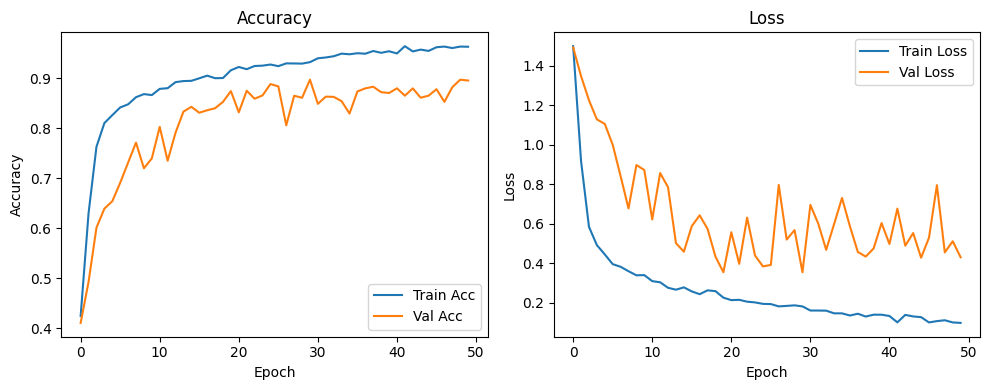

In [ ]:
# 1. Plot training curves
def plot_training_curves(history):
    plt.figure(figsize=(10, 4))
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_training_curves(history)

In [ ]:
# 2. Classification report
report = classification_report(y_true, y_pred, target_names=unity_class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score,support
BottomCenter,0.000000,0.000000,0.000000,0.000000
BottomLeft,0.908046,0.916828,0.912416,1034.000000
BottomRight,0.911817,0.921021,0.916396,1684.000000
MiddleLeft,0.942511,0.890828,0.915941,2006.000000
MiddleRight,0.945523,0.874314,0.908526,2005.000000
TopCenter,0.885568,0.836290,0.860224,1240.000000
TopLeft,0.844491,0.952438,0.895222,1682.000000
TopRight,0.922270,0.888823,0.905238,1682.000000
accuracy,0.897644,0.897644,0.897644,0.897644
macro avg,0.795028,0.785068,0.789245,11333.000000


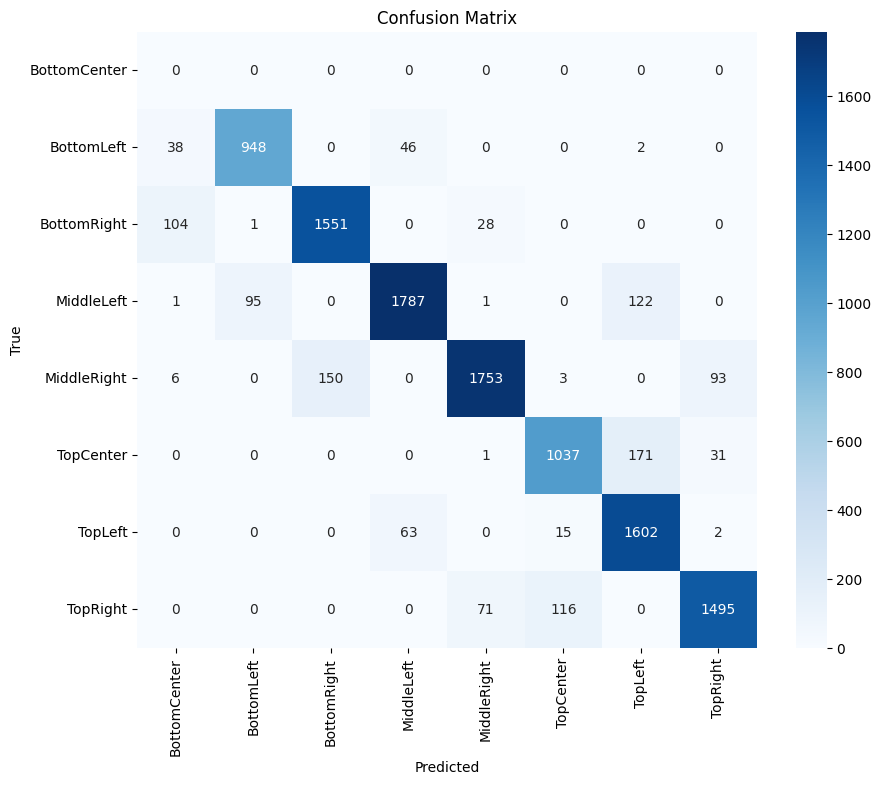

In [ ]:
# 3. Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


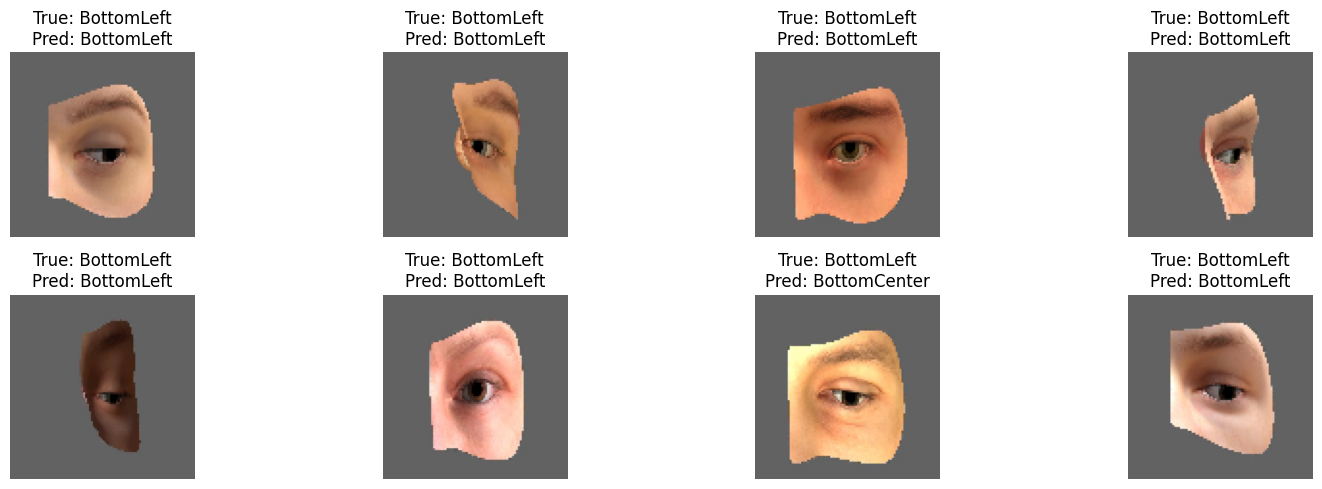

In [ ]:
# 4. Inference examples
def plot_inference_examples(generator, y_pred, class_names, num_examples=8):
    fig, axes = plt.subplots(2, num_examples // 2, figsize=(16, 5))
    axes = axes.flatten()
    for i in range(num_examples):
        img, label = generator[i]
        pred_label = class_names[np.argmax(model.predict(np.expand_dims(img[0], axis=0)))]
        true_label = class_names[np.argmax(label[0])]
        axes[i].imshow(img[0])
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Display
plot_inference_examples(unity_test_gen, y_pred, class_names)